In [4]:
import re
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib import style, colors
from matplotlib import gridspec

matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)



use all calls from strelka: this is prefered since this takes into consideration of all soamtic calls:snvs and indels, high/moderate/low/modifier impacts.

In [144]:
# f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/HIGH_MODERATE_SNV_summary_with_normal_with_AF.tsv'
f1 = '/projects/trans_scratch/validations/EXPANDS/124_patients/HIGH_MODERATE_SNV_summary_with_normal_with_AF.tsv'
df = pd.read_csv(f1, sep='\t', comment='#', usecols=['gene', 'patient_ID', 'adj_t_DNA_AF', 'in_strelka'])
# df = pd.read_csv(f1, sep='\t', comment='#', usecols=['gene', 'patient_ID', 't_DNA_AF', 'in_strelka'])
df.head(2)

/home/szong/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,gene,patient_ID,in_strelka,adj_t_DNA_AF
0,WASH7P,HTMCP-03-06-02175_malignant,not_in_strelka,0.35
1,WASH7P,HTMCP-03-06-02238_malignant,not_in_strelka,0.3


In [145]:
# this should have adj_t_DNA_AF value
df[(df.patient_ID == 'HTMCP-03-06-02341_malignant') & (df.in_strelka == 'in_strelka')].head(2)

,gene,patient_ID,in_strelka,adj_t_DNA_AF
11945,PLEKHG5,HTMCP-03-06-02341_malignant,in_strelka,0.16
49181,SERINC2,HTMCP-03-06-02341_malignant,in_strelka,0.18


In [146]:
# filter for strelka calls
df = df[df.in_strelka == 'in_strelka']
df.head(2)

,gene,patient_ID,in_strelka,adj_t_DNA_AF
3,WASH7P,HTMCP-03-06-02149_malignant,in_strelka,0.04
304,SAMD11,HTMCP-03-06-02214_malignant,in_strelka,0.32


In [147]:
df.shape

(45646, 4)

In [148]:
df['patient'] = df['patient_ID'].str.replace('_malignant', '')
df = df.drop('patient_ID', axis=1)

In [149]:
df.head(2)

,gene,in_strelka,adj_t_DNA_AF,patient
3,WASH7P,in_strelka,0.04,HTMCP-03-06-02149
304,SAMD11,in_strelka,0.32,HTMCP-03-06-02214


In [150]:
# add in hiv status and histology
# get meta track for example histology
f3 ='/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/mutation_load_clinic.txt'
df3 = pd.read_csv(f3, sep='\t')
df3 = df3[['patient', 'HIV_status', 'Putative_histology']]
# df3 = df3.set_index('patient')#.stack().reset_index()
df3.head(2)

,patient,HIV_status,Putative_histology
0,HTMCP-03-06-02001,Positive,Squamous
1,HTMCP-03-06-02002,Negative,Squamous


In [151]:
dfm = pd.merge(df, df3, left_on='patient', right_on='patient')

In [152]:
# dfm = dfm[dfm.adj_t_DNA_AF != 'na']
# dfm = dfm[dfm.t_DNA_AF != 'na']

In [153]:
dfm.head()

,gene,in_strelka,adj_t_DNA_AF,patient,HIV_status,Putative_histology
0,WASH7P,in_strelka,0.04,HTMCP-03-06-02149,Negative,Squamous
1,RSG1,in_strelka,0.16,HTMCP-03-06-02149,Negative,Squamous
2,MST1P9,in_strelka,0.28,HTMCP-03-06-02149,Negative,Squamous
3,ZMYM1,in_strelka,0.14,HTMCP-03-06-02149,Negative,Squamous
4,NCDN,in_strelka,0.44,HTMCP-03-06-02149,Negative,Squamous


In [154]:
dfm.shape

(45363, 6)

In [155]:
# dfm[dfm.reanne_HIV_status == 'Positive']['adj_t_DNA_AF'].value_counts()

In [156]:
# dfm[dfm.reanne_HIV_status == 'Positive'][y]

In [157]:
# dfm = dfm[dfm.patient == 'HTMCP-03-06-02149']

In [158]:
# dfm[dfm.reanne_HIV_status == 'Negative']

In [159]:
pat1 = dfm.patient.drop_duplicates()
pat2 = df3.patient  

In [160]:
pat1.head(2)

0      HTMCP-03-06-02149
130    HTMCP-03-06-02214
Name: patient, dtype: object

In [161]:
pat2[~pat2.isin(pat1)].dropna()

Series([], Name: patient, dtype: object)

In [162]:
dfm.head(2)   

,gene,in_strelka,adj_t_DNA_AF,patient,HIV_status,Putative_histology
0,WASH7P,in_strelka,0.04,HTMCP-03-06-02149,Negative,Squamous
1,RSG1,in_strelka,0.16,HTMCP-03-06-02149,Negative,Squamous


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 11.5 s, sys: 301 ms, total: 11.8 s
Wall time: 11.9 s


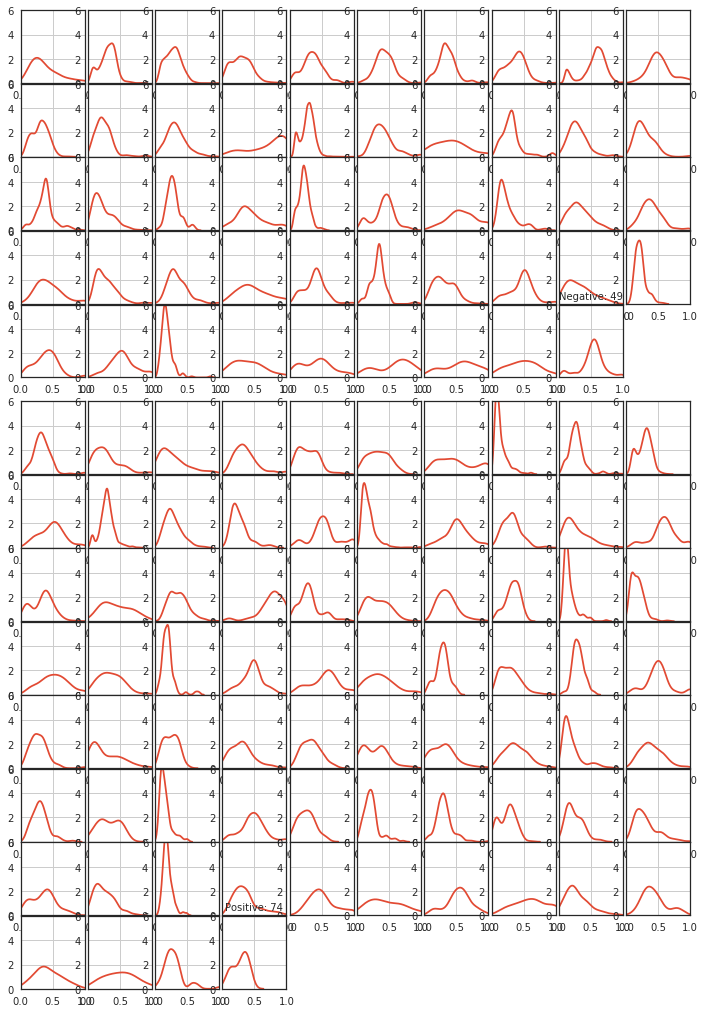

In [163]:
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25

    fig = plt.figure(facecolor='w', figsize=(12,18))
    x1 = 'HIV_status'
    x2 = 'combo'
    x3 = 'Putative_histology'
    x4 = 'patient'
    y = 'adj_t_DNA_AF'
#     y = 't_DNA_AF'
    groups = dfm[x1].unique().tolist()

    gs = gridspec.GridSpec(2, 1, height_ratios=[5,8], width_ratios=[1], 
                           wspace=0.05, # horizontal space
                           hspace=0.05  # vertical space
                          )
    for n, gr in enumerate(groups):
        dfm1  = dfm[dfm[x1] == gr]
        pats = dfm1[x4].unique().tolist()
        gs01 = gridspec.GridSpecFromSubplotSpec(int(len(pats)/10+1), 10,  subplot_spec=gs[n], wspace=0.05, hspace=0.01)
        
        for k, pat in enumerate(pats):
            ax = fig.add_subplot(gs01[k], facecolor='white')           
            sns.distplot(dfm[dfm[x4] == pat][y].astype(float), hist=False)
            ax.set_xlim(0,1)
            ax.set_ylim(0,6)
            ax.set_xlabel('')
        ax.set_title('{0}: {1}'.format(gr, len(pats)), fontsize=10)

   
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/AF_distribution_by_patient.png'
%time plt.savefig(of, bbox_inches='tight',dpi=300)

plt.show()
plt.close()

/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 2.58 s, sys: 66 ms, total: 2.65 s
Wall time: 2.67 s


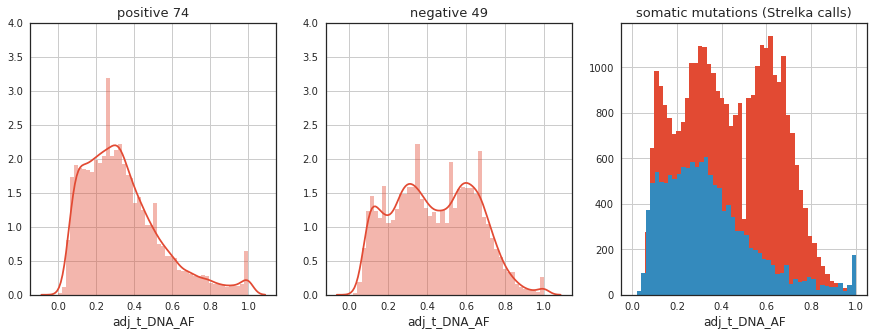

In [164]:
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25

    fig = plt.figure(facecolor='w', figsize=(15,5))
    x1 = 'HIV_status'
    x2 = 'combo'
    x3 = 'Putative_histology'
    y = 'adj_t_DNA_AF'
#     y = 't_DNA_AF'
    ax1 = plt.subplot(131,facecolor='w')
    # sns distribution plot
    dfm1 = dfm[dfm.HIV_status == 'Positive']
    patients = dfm1.patient.unique().tolist()
    sns.distplot(dfm1[y].astype(float))
    ax1.set_ylim(0,4)
    plt.title('positive {}'.format(len(patients)),  fontsize=13)


    ax2 = plt.subplot(132,facecolor='w')
    dfm2 = dfm[dfm.HIV_status == 'Negative']
    patients = dfm2.patient.unique().tolist()
    sns.distplot(dfm2[y].astype(float))
    ax2.set_ylim(0,4)
    plt.title('negative {}'.format(len(patients)), fontsize=13)


    # dfm2  = dfm[dfm.reanne_HIV_status == 'Negative']
    # patients = dfm2.patient.unique().tolist()
    # for patient in patients[:10]:
    #     sns.distplot(dfm[dfm.patient == patient][y].astype(float), hist=False)


    # density plot
    ax3 = plt.subplot(133,facecolor='w')
    ax3.hist(dfm[dfm.HIV_status == 'Negative'][y].astype(float), bins=50)
    ax3.hist(dfm[dfm.HIV_status == 'Positive'][y].astype(float), bins=50)

    ax3.set_title("somatic mutations (Strelka calls)",  fontsize=13)
    ax3.set(xlabel='adj_t_DNA_AF')
#     ax3.set(xlabel='t_DNA_AF')

of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/AF_distribution.png'
%time plt.savefig(of, bbox_inches='tight',dpi=300)
plt.show()
plt.close()

kernel density estimate + histogram, area under the curve = 1


should use tumour content adjusted AF
individual patient